In [1]:
%matplotlib qt5

In [2]:
import numpy as np
from scipy import signal, stats
from skimage.measure import label, regionprops
import hdf5storage
import mne
import matplotlib.pyplot as plt

In [3]:
def detect_IEDs(signal_in, srate, t_epoch):
    """
    Detects Interictal Epileptiform Discharges (IEDs) in a given signal.
    Parameters:
    signal_in (numpy.ndarray): The input signal from which IEDs are to be detected.
    srate (float): The sampling rate of the input signal.
    t_epoch (tuple): A tuple containing the start and end times of the epoch relative to the detected event.
    Returns:
    numpy.ndarray: A matrix containing information about detected IEDs. The matrix has four columns:
        - Column 0: Location of discharge maximum.
        - Column 1: Trial onset (location of maximum - start time of epoch * sampling rate).
        - Column 2: Trial offset (location of maximum + end time of epoch * sampling rate).
        - Column 3: Offset relative to maximum location (center of epoch * sampling rate).
    """
    
    # 1. Get envelope from raw signal
    amplit_envelope = np.abs(signal.hilbert(signal_in))
    amplit_envelope = stats.zscore(amplit_envelope, axis=1) 

    # 2. Band-pass filtering 
    filter_order = 10
    low_cut = 25 * 0.8 # low cut-off frequency for high-pass filter (20% less to compensate for attenuation)
    b_hp, a_hp = signal.butter(filter_order, (low_cut / srate) * 2, 'high', analog=False)
    high_cut = 80 * 1.2 # high cut-off frequency for low-pass filter (20% less to compensate for attenuation)
    b_lp, a_lp = signal.butter(filter_order, (high_cut / srate) * 2, 'low', analog=False) 

    # apply filtering and get envelope
    filt_signal_in = signal.filtfilt(b_hp, a_hp, signal_in) # HP
    filt_signal_in = signal.filtfilt(b_lp, a_lp, filt_signal_in) #LP

    filt_signal_in_envelope = np.abs(signal.hilbert(filt_signal_in))

    # 3. Normalize
    filt_signal_in_envelope = stats.zscore(filt_signal_in_envelope, axis=1)

    # 4. Detect events above threshold and time criterion
    cutoff  = 2
    min_t   = 0.02 * srate
    max_t   = 0.1 * srate

    # 5. only find consecutive segments 
    aboveThreshold = (filt_signal_in_envelope > cutoff) # - Samples of threshhold
    aboveThreshold[amplit_envelope < cutoff] = 0  # - Remove if raw sd is < cutoff

    # Identify continuous one and apply time criterion
    spanLocs = label(aboveThreshold) # Label connected regions
    regions = regionprops(spanLocs) # Measure region properties (area)
    spanLength = np.array([region.area for region in regions]) # Extract the length (area) of each region
    goodSpans = np.where((spanLength > min_t) & (spanLength < max_t))[0] # Find indices of spans with lengths within the specified range

    # 6. Create trl matrix 
    # [Note:] trl matrix is a 4-column matrix containing the following information for each trial: 
    #   - [:,0]  Location of discharge maximum
    #   - [:,1]  Trial onset: loc_maximum - trange*srate
    #   - [:,2]  Trial offset: loc_maximum - trange*srate
    #   - [:,3]  Offset relative to maximum location (center): trange*srate

    trl = np.zeros((len(goodSpans),4))

    for g in range(len(goodSpans)):

        currentepochidx = np.where(spanLocs == (goodSpans[g]+1))[1]
        currentepochvals = filt_signal_in_envelope[0,currentepochidx]

        # Find the max in this range
        maxloc = np.argmax(currentepochvals)
        maxloc = maxloc + currentepochidx[0]

        # Create the trl
        trl[g,:] = [maxloc, maxloc-np.abs(t_epoch[0])*srate, maxloc+np.abs(t_epoch[1])*srate, np.abs(t_epoch[0])*srate]

    # 7. Eliminate events that are within 1 sec -------------------------------
    tr_el = np.zeros(trl.shape[0])

    for tr in range(1, trl.shape[0]):
        if (trl[tr,0] - trl[tr-1,0]) <= srate:
            tr_el[tr] = 1
        else:
            pass

    #print(tr_el)

    trl = np.delete(trl, np.where(tr_el == 1), axis=0)

    return trl

def ripple_char(signal_in, locs, maxsamples):
    """
    Analyze ripple characteristics in a given signal.
    Parameters:
    signal_in (numpy.ndarray): The input signal array.
    locs (list or numpy.ndarray): Indices of candidate ripple peaks.
    maxsamples (int): The maximum number of samples to consider around each candidate peak.
    Returns:
    tuple: A tuple containing three numpy arrays:
        - ripplepeaks (numpy.ndarray): Number of peaks in each segment.
        - rippletrough (numpy.ndarray): Indices of the trough closest to each ripple peak.
        - sharptransient (numpy.ndarray): Sharpest transient for later spike removal.
    """

    # - Pre-define output variables -
    # -------------------------------------------------------------------------
    # Pre-define output variables
    ripplepeaks = np.full(len(locs), np.nan)
    rippletrough = np.full(len(locs), np.nan)
    sharptransient = np.full(len(locs), np.nan)

    # - Go through ripple candidates -
    for idx in range(len(locs)):
        
        # 1. Determine window -------------------------------------------------
        s_start = np.round(locs[idx] - maxsamples/2).astype(int) # start sample
        s_end = np.round(locs[idx] + maxsamples/2).astype(int) # stop sample
        datasegm_trial  = signal_in[0,s_start:s_end]
        #datasegm_time = times[s_start:s_end]
        
        # 2. Find all troughs close to candidate ripple peak ------------------
        idxloc, _ = signal.find_peaks((-1)*datasegm_trial)
        pks2 = datasegm_trial[idxloc]
        idxloc = idxloc + s_start # offset to the real indexs
        
        # 3. Save ripple characteristics --------------------------------------
        if len(idxloc) == 0 or len(idxloc) == 1:
            ripplepeaks[idx] = np.nan
            rippletrough[idx] = np.nan
            sharptransient[idx] = np.nan
        else:
            ripplepeaks[idx] = len(idxloc) # - Number of peaks in segment
            rippletrough[idx] = idxloc[np.argmin(np.abs(idxloc-locs[idx]))] # - Datapoint of trough closest to ripple peak idx 

            # 4. Flag sharpest transient ------------------------------------------
            pksz = stats.zscore(pks2)
            pksdiff = pksz[1:]-pksz[:-1]
            sharptransient[idx] = np.max(np.abs(pksdiff))                    # - Mark sharpest transient for later spike removal


    return ripplepeaks, rippletrough, sharptransient

def num_discharges_in_ripple_trial(trial_start, trial_end, discharge_pks):
    """
    Calculate the number of discharges within each ripple trial.
    Parameters:
    trial_start (array-like): An array of start times for each trial.
    trial_end (array-like): An array of end times for each trial.
    discharge_pks (array-like): An array of discharge peak times.
    Returns:
    numpy.ndarray: An array containing the number of discharges for each trial.
    """
    
    nodischarges = np.zeros(len(trial_start))

    for tr_idx in range(len(trial_start)):

        currentepoch_start = trial_start[tr_idx]
        currentepoch_end = trial_end[tr_idx]
        nodischarges[tr_idx] = np.sum((discharge_pks >= currentepoch_start) & (discharge_pks <= currentepoch_end))

    return nodischarges


def detect_ieeg_ripples(signal_in, srate, epileptic_events, t_range = 2.5):
    """
    Detects ripples in an intracranial EEG (iEEG) signal.
    Parameters:
    signal_in (numpy.ndarray): The input iEEG signal.
    srate (int): The sampling rate of the input signal.
    epileptic_events (numpy.ndarray): Array containing information about detected epileptic events.
    t_range (float, optional): Time range for ripple detection. Default is 2.5 seconds.
    Returns:
    numpy.ndarray: A matrix containing information about detected ripples.
    """

    # 1. Band-pass filtering 
    print('- Filtering and Hilbert transform [-]')
    filter_order = 10
    low_cut = 80 * 0.8 # [Hz] low cut-off frequency for high-pass filter (20% less to compensate for attenuation)
    b_hp, a_hp = signal.butter(filter_order, (low_cut / srate) * 2, btype = 'highpass', analog=False) 
    high_cut = 120 * 1.2 # [Hz] high cut-off frequency for low-pass filter (20% more to compensate for attenuation)
    b_lp, a_lp = signal.butter(filter_order, (high_cut / srate) * 2, btype = 'lowpass', analog=False)

    # apply filtering and get envelope
    filt_signal_in = signal.filtfilt(b_hp, a_hp, signal_in) # HP
    filt_signal_in = signal.filtfilt(b_lp, a_lp, filt_signal_in) #LP

    # Hilbert transform
    filt_signal_in_envelope = np.abs(signal.hilbert(filt_signal_in))

    b_lp_h, a_lp_h = signal.butter(filter_order, (10*1.2 / srate) * 2, btype = 'lowpass', analog=False) #10 Hz LP on hilbert amplitude
    filt_signal_in_envelope = signal.filtfilt(b_lp_h, a_lp_h, filt_signal_in_envelope) 

    # Normalize with zscore
    filt_signal_in_envelope = stats.zscore(filt_signal_in_envelope, axis=1)


    # - Find candidate ripple events ------------------------------------------
    print('- Looking candidate ripple events [-]')
    # [Notes:]  - Minimum duration = 25 ms
    #           - Maximum duration = 200 ms  
    #           - Minimum peak distance = 500 ms (avoiding overlap)
    # -------------------------------------------------------------------------
    minsamples = np.round((25/1000) * srate) # Minimum duration 25 ms (sampling points) %note: orig. 20ms
    maxsamples = np.round((200/1000) * srate) # Maximum duration 200 ms (sampling points) 
    MPD        = np.round((500/1000) * srate) # Minimum peak distance 500 ms (sampling points)

    # - Determine minimum & maximum peak height & distance - - - - - - - - - - 
    # [Notes:]  - pks = peak values
    #           - locs = locations 
    #           - width = distance between peaks 
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Find peaks in the filtered signal envelope
    peaks, properties = signal.find_peaks(filt_signal_in_envelope[0], height=2, width=(minsamples, maxsamples), distance=MPD)
    pks = properties['peak_heights']
    locs = peaks
    width = properties['widths']

    # - Now go through the signal and determine ripple characteristics --------
    print('- Determine ripple characteristics [-]')
    ripplepeaks, rippletrough, sharptransient = ripple_char(signal_in, locs, maxsamples)

    # - Render peak width into secs -------------------------------------------
    width = width / srate

    # - Render ripple peaks per epoch into Hz ---------------------------------
    ripplepeaks = ripplepeaks * (srate/maxsamples) 

    # - Remove NaN values -----------------------------------------------------
    # TODO

    # - Create a basic trl ----------------------------------------------------
    # [Note:] Defines trial centered around ripple trough as follows:
    #   - [:,0]  Trial onset: ripple trough - settings.trange*data.fsample [samples]
    #   - [:,1]  Trial offset: ripple trough + settings.trange*data.fsample [samples]
    #   - [:,2]  Trigger offset: set at -settings.trange*data.fsample [samples]
    #   - [:,3]  Ripple peak amplitude (z-score)
    #   - [:,4]  Ripple frequency [Hz]
    #   - [:,5]  Indication of sharpest transient in trial
    #   - [:,6]  Ripple duration in seconds
    #   - [:,7]  Cross referencing with discharge detection (optional) : amount of detected discharges in trial
    # -------------------------------------------------------------------------  

    # Si hay informacion sobre las descargas
    if len(epileptic_events)!=0:
        discharge_pks = epileptic_events[:,0]
        #num_discharges = np.zeros(len(rippletrough))
        num_discharges = num_discharges_in_ripple_trial(rippletrough-t_range*srate, rippletrough+t_range*srate, discharge_pks)
        trl = np.column_stack((rippletrough-t_range*srate, rippletrough+t_range*srate, np.full(len(rippletrough), -2.5*srate), pks, ripplepeaks, sharptransient, width, num_discharges))

    # Si NO hay informacion sobre las descargas
    else:
        trl = np.column_stack((rippletrough-t_range*srate, rippletrough+t_range*srate, np.full(len(rippletrough), -2.5*srate), pks, ripplepeaks, sharptransient, width, np.zeros(len(rippletrough))))


    # - Remove any potential trials that: -------------------------------------
    #       - Start prior to the recording onset (i.e., ripple detected at the very start)
    #       - Exceed the recording (i.e., ripple detected at the very end
    # -------------------------------------------------------------------------
    trl = trl[trl[:,0]>0,:] # - Remove trial prior to recording onset
    trl = trl[trl[:,1]<len(signal_in[0]),:] # - Remove trials that occur past recording end


    # 2. Cleaning up the trl matrix
    print('- Cleaning up the trl matrix according to criteria [-]')

    amp_th = [2,4] # amplitude threshold
    minfreq = 80; # minimum frequency
    sharptransient_th = 2 # sharp transient threshold
    #overlap = 0 # ??
    trange = 2.5
    min_num_ripples = 10

    # Compute logical AND for multiple conditions
    tIndex = np.logical_and.reduce((
        trl[:,3] >= amp_th[0], trl[:,3] <= amp_th[1], # - Amplitude criteria
        trl[:,4] > minfreq, # - Frequency criteria
        trl[:,5] < sharptransient_th, # - Sharp transient criteria
        trl[:,6] > (np.median(trl[:,6]) - np.std(trl[:,6])), # - Duration criteria
        trl[:,7] == 0 # - IED criteria  
    ))

    # Se concatena como una nueva columna cuales son los putative-ripples que pasan el proceso de limpienza (=1) y los que no (=0)
    trl = np.column_stack((trl, tIndex))

    return trl


In [52]:
filter_order = 10
low_cut = 80*1.2 # [Hz] low cut-off frequency for high-pass filter
b_hp, a_hp = signal.butter(filter_order, ((low_cut / 1000) * 2)*0.8, 'high', analog=False)
high_cut = 120 # [Hz] high cut-off frequency for low-pass filter
b_lp, a_lp = signal.butter(filter_order, 2*np.pi*high_cut, btype = 'lowpass', analog=True)
b_lp_h, a_lp_h = signal.butter(filter_order, (10*1.2 / 1000) * 2, btype = 'lowpass', analog=False) #10 Hz LP on hilbert amplitude

#b, a = signal.butter(4, 0.5, 'low')
#w, h = signal.freqs(b_hp, a_hp)
w, h = signal.freqz(b_lp_h, a_lp_h, worN=8000)
plt.figure()
plt.plot(0.5 * 1000 * w / np.pi, np.abs(h), 'b')
#plt.title(f'{filter_type.capitalize()}-pass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.show()


'''plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
#plt.axvline((low_cut / 1000) * 2, color='green') # cutoff frequency
plt.show()'''

"plt.semilogx(w, 20 * np.log10(abs(h)))\nplt.title('Butterworth filter frequency response')\nplt.xlabel('Frequency [radians / second]')\nplt.ylabel('Amplitude [dB]')\nplt.margins(0, 0.1)\nplt.grid(which='both', axis='both')\n#plt.axvline((low_cut / 1000) * 2, color='green') # cutoff frequency\nplt.show()"

### Para levantar la data del papar de Ngo & Staresina, 2020 (eLife)

In [76]:
# FILEPATH: signal
filepath = '/home/lfa-01/Documentos/Data_NgoStaresina_eLife2020_OSF/Raw data/EEGs/pat03_HIPP.mat'
mat_data = hdf5storage.loadmat(filepath)

# Now you can work with the loaded data
times = mat_data['time'][0][0][0]
fsample = mat_data['fsample'][0][0]
ch_label = str(mat_data['label'][0][0][0])
cant_chan = len([ch_label])
ieeg_signal = mat_data['trial'][0][0][0]
ieeg_signal = np.reshape(ieeg_signal, (cant_chan, len(ieeg_signal)))


# Demean and Detrend signal
ieeg_signal = signal.detrend(ieeg_signal, axis=1, type='linear')
ieeg_signal = ieeg_signal - np.mean(ieeg_signal, axis=1, keepdims=True)

# IMPORTANTE: me quedo con un pedazo de la señal

N_samples = 2000*int(fsample)
ieeg_signal = ieeg_signal[:, :N_samples]
times = times[:N_samples]


In [32]:
print(ieeg_signal.shape)
print(times.shape)
print(fsample)

(1, 2000000)
(2000000,)
1000.0


In [34]:
# FILEPATH: events info
filepath_evt = '/home/lfa-01/Documentos/Data_NgoStaresina_eLife2020_OSF/Raw data/Ripples/pat03_HIPP_ripples.mat'
mat_evt_info = hdf5storage.loadmat(filepath_evt)

In [35]:
orig_ripples_detect = mat_evt_info['EvtInfo'][0][3][0] # del struct EvtInfo, el tercer vector es el punto medio de los ripples identificados
events_array_orig = np.column_stack( (orig_ripples_detect, np.zeros(len(orig_ripples_detect)), np.ones(len(orig_ripples_detect))))

events_array_orig = events_array_orig.astype(int)
print(events_array_orig)

events_id_orig = {'putative_ripple_Ngo': 1}
event_color_orig = {'putative_ripple_Ngo': 'm'}

[[ 1543107        0        1]
 [ 1549251        0        1]
 [ 1586519        0        1]
 ...
 [29713132        0        1]
 [29720559        0        1]
 [29724555        0        1]]


Graficacion de los eventos ripple identificados en el paper de Ngo

In [ ]:
seeg_channels = mne.pick_types(mne_data.info, seeg=True)
mne_data.plot(duration=30, order=seeg_channels, n_channels=len(seeg_channels),
         remove_dc=False, scalings = 'auto', block=True, color=dict(seeg='b'),
         events=events_array_orig, event_id=events_id_orig, event_color=event_color_orig)

Deteccion de IED siguiendo el algoritmo de Helfrich

In [36]:
trl_discharges = detect_IEDs(ieeg_signal, int(fsample), [-2.5,2.5])
print(trl_discharges)

[[  3147.    647.   5647.   2500.]
 [ 65989.  63489.  68489.   2500.]
 [ 80402.  77902.  82902.   2500.]
 [ 98664.  96164. 101164.   2500.]
 [104403. 101903. 106903.   2500.]
 [139542. 137042. 142042.   2500.]
 [143564. 141064. 146064.   2500.]]


Con los eventos detectados creo objetos MNE continuo y epocas para visualizaciones

In [37]:
# Convert the loaded data to a MNE-Python object
mne_data = mne.io.RawArray(ieeg_signal, info=mne.create_info(ch_names=[ch_label], sfreq=fsample, ch_types=['seeg']*cant_chan))

Creating RawArray with float64 data, n_channels=1, n_times=2000000
    Range : 0 ... 1999999 =      0.000 ...  1999.999 secs
Ready.


In [38]:
events_IED_array_orig = np.column_stack(  (trl_discharges[:,0].astype(int), np.zeros(len(trl_discharges[:,0])).astype(int), np.ones(len(trl_discharges[:,0])).astype(int) ) )
print(events_IED_array_orig)

events_IED_id_orig = {'putative_IED': 1}
event_IED_color_orig = {'putative_IED': 'm'}

[[  3147      0      1]
 [ 65989      0      1]
 [ 80402      0      1]
 [ 98664      0      1]
 [104403      0      1]
 [139542      0      1]
 [143564      0      1]]


In [39]:
seeg_channels = mne.pick_types(mne_data.info, seeg=True)
mne_data.plot(duration=30, order=seeg_channels, n_channels=len(seeg_channels),
         remove_dc=False, scalings = 'auto', block=True, color=dict(seeg='b'),
         events=events_IED_array_orig, event_id=events_IED_id_orig, event_color=event_IED_color_orig)

Channels marked as bad:
none


In [40]:
epochs = mne.Epochs(mne_data, events_IED_array_orig, tmin=-2.5, tmax=2.5, event_id=events_IED_id_orig, preload=True)
epochs.plot_image(combine="mean")

Not setting metadata
7 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 7 events and 5001 original time points ...
0 bad epochs dropped
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


/tmp/ipykernel_371444/2601915031.py:2: RuntimeWarning: Only one channel in group "seeg"; cannot combine by method "mean".
  epochs.plot_image(combine="mean")
/tmp/ipykernel_371444/2601915031.py:2: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  epochs.plot_image(combine="mean")


[<Figure size 640x480 with 3 Axes>]

Usando Morlet

In [113]:
freqs = np.logspace(*np.log10([4, 160]), num=30)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)

Usando Multitapers

In [41]:
freqs = np.logspace(*np.log10([4, 160]), num=45)
n_cycles = freqs / 2.0  # different number of cycle per frequency
time_bandwidth = 8.0 
power, itc = epochs.compute_tfr(
    method='multitaper',
    freqs=freqs, 
    n_cycles=n_cycles, 
    time_bandwidth = time_bandwidth,
    return_itc=True, 
    decim=3, 
    n_jobs=1,
    average=True)

In [42]:
power.plot(baseline=(-2.5, -1.5), tmin=-1., tmax=1., mode="logratio")

Applying baseline correction (mode: logratio)


[<Figure size 640x480 with 2 Axes>]

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).


/tmp/ipykernel_371444/221005036.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  mean_spectrum.plot(xscale='log', average=True)


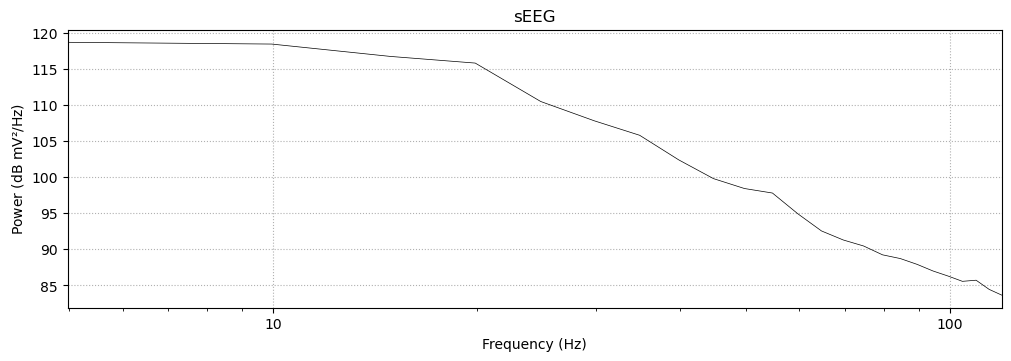

In [43]:
epochs_spectrum = epochs.compute_psd(method="multitaper", tmin=-0.1, tmax=0.1, fmin=4, fmax=120)
mean_spectrum = epochs_spectrum.average()
mean_spectrum.plot(xscale='log', average=True) 

TEST: Algoritmo de deteccion de ripples

In [70]:
# USANDO LA FUNCION detect_ieeg_ripples
trl_ripples = detect_ieeg_ripples(signal_in=ieeg_signal, srate=int(fsample), epileptic_events=trl_discharges, t_range = 2.5)

- Filtering and Hilbert transform [-]


- Looking candidate ripple events [-]
- Determine ripple characteristics [-]


Failed to enable GUI event loop integration for 'qt5'
Traceback (most recent call last):
  File "/home/lfa-01/mambaforge-pypy3/envs/env_mne_1_7/lib/python3.12/site-packages/debugpy/_vendored/pydevd/pydev_ipython/matplotlibtools.py", line 30, in do_enable_gui
    enable_gui(guiname)
  File "/home/lfa-01/mambaforge-pypy3/envs/env_mne_1_7/lib/python3.12/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhook.py", line 540, in enable_gui
    return gui_hook(app)
           ^^^^^^^^^^^^^
  File "/home/lfa-01/mambaforge-pypy3/envs/env_mne_1_7/lib/python3.12/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhook.py", line 223, in enable_qt5
    from pydev_ipython.inputhookqt5 import create_inputhook_qt5
  File "/home/lfa-01/mambaforge-pypy3/envs/env_mne_1_7/lib/python3.12/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhookqt5.py", line 24, in <module>
    from pydev_ipython.qt_for_kernel import QtCore, QtGui
  File "/home/lfa-01/mambaforge-pypy3/envs/env_mne_1_7/lib/

- Cleaning up the trl matrix according to criteria [-]


In [63]:
print(trl_ripples.shape)
print(trl_ripples[trl_ripples[:,8]==1,:])

(186, 9)
[[ 3.18299000e+05  3.23299000e+05 -2.50000000e+03  2.22595453e+00
   1.90000000e+02  1.58490994e+00  1.67736718e-01  0.00000000e+00
   1.00000000e+00]
 [ 3.61767000e+05  3.66767000e+05 -2.50000000e+03  2.73703967e+00
   1.50000000e+02  1.46936409e+00  1.39780691e-01  0.00000000e+00
   1.00000000e+00]
 [ 9.12640000e+05  9.17640000e+05 -2.50000000e+03  3.21209770e+00
   1.40000000e+02  1.40130937e+00  1.66734302e-01  0.00000000e+00
   1.00000000e+00]
 [ 9.62037000e+05  9.67037000e+05 -2.50000000e+03  2.07823759e+00
   1.05000000e+02  1.61250051e+00  7.17448342e-02  0.00000000e+00
   1.00000000e+00]
 [ 1.00182000e+06  1.00682000e+06 -2.50000000e+03  2.05154504e+00
   1.55000000e+02  1.43520488e+00  1.17830893e-01  0.00000000e+00
   1.00000000e+00]
 [ 1.03408500e+06  1.03908500e+06 -2.50000000e+03  2.47935703e+00
   1.70000000e+02  1.83541186e+00  5.43850668e-02  0.00000000e+00
   1.00000000e+00]
 [ 1.03575600e+06  1.04075600e+06 -2.50000000e+03  2.22472740e+00
   1.55000000e+02  

In [13]:
# TEST para general el algoritmo de deteccion de ripples

# ------------
signal_in = ieeg_signal
srate = int(fsample)
t_range = 2.5 # time range ± ripple trough (sec)
epileptic_events = trl_discharges
# ------------

# 1. Band-pass filtering 
filter_order = 4
low_cut = 80 # [Hz] low cut-off frequency for high-pass filter
b_hp, a_hp = signal.butter(filter_order, (low_cut / srate) * 2, btype = 'highpass')
high_cut = 120 # [Hz] high cut-off frequency for low-pass filter
b_lp, a_lp = signal.butter(filter_order, (high_cut / srate) * 2, btype = 'lowpass')

# apply filtering and get envelope
filt_signal_in = signal.filtfilt(b_hp, a_hp, signal_in) # HP
filt_signal_in = signal.filtfilt(b_lp, a_lp, filt_signal_in) #LP

# Hilbert transform
filt_signal_in_envelope = np.abs(signal.hilbert(filt_signal_in))

b_lp_h, a_lp_h = signal.butter(filter_order, (10 / srate) * 2, btype = 'lowpass') #10 Hz LP on hilbert amplitude
filt_signal_in_envelope = signal.filtfilt(b_lp_h, a_lp_h, filt_signal_in_envelope) 

# Normalize with zscore
filt_signal_in_envelope = stats.zscore(filt_signal_in_envelope, axis=1);


# - Find candidate ripple events ------------------------------------------
# [Notes:]  - Minimum duration = 25 ms
#           - Maximum duration = 200 ms  
#           - Minimum peak distance = 500 ms (avoiding overlap)
# -------------------------------------------------------------------------
minsamples = np.round((25/1000) * srate) # Minimum duration 25 ms (sampling points) %note: orig. 20ms
maxsamples = np.round((200/1000) * srate) # Maximum duration 200 ms (sampling points) 
MPD        = np.round((500/1000) * srate) # Minimum peak distance 500 ms (sampling points)

# - Determine minimum & maximum peak height & distance - - - - - - - - - - 
# [Notes:]  - pks = peak values
#           - locs = locations 
#           - width = distance between peaks 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Find peaks in the filtered signal envelope
peaks, properties = signal.find_peaks(filt_signal_in_envelope[0], height=2, width=(minsamples, maxsamples), distance=MPD)
pks = properties['peak_heights']
locs = peaks
width = properties['widths']

# - Now go through the signal and determine ripple characteristics --------
print('- Determine ripple characteristics [-]')
ripplepeaks, rippletrough, sharptransient = ripple_char(signal_in, locs, maxsamples)

# - Render peak width into secs -------------------------------------------
width = width / srate

# - Render ripple peaks per epoch into Hz ---------------------------------
ripplepeaks = ripplepeaks * (srate/maxsamples) 

# - Remove NaN values -----------------------------------------------------
# TODO

# - Create a basic trl ----------------------------------------------------
# [Note:] Defines trial centered around ripple trough as follows:
#   - [:,0]  Trial onset: ripple trough - settings.trange*data.fsample
#   - [:,1]  Trial offset: ripple trough + settings.trange*data.fsample
#   - [:,2]  Trigger offset: set at -settings.trange*data.fsample 
#   - [:,3]  Ripple peak amplitude (z-score)
#   - [:,4]  Ripple frequency
#   - [:,5]  Indication of sharpest transient in trial
#   - [:,6]  Ripple duration in seconds
#   - [:,7]  Cross referencing with discharge detection (optional) : amount of detected discharges in trial
# -------------------------------------------------------------------------  

# Si hay informacion sobre las descargas
if len(epileptic_events)!=0:
       discharge_pks = epileptic_events[:,0]
       #num_discharges = np.zeros(len(rippletrough))
       num_discharges = num_discharges_in_ripple_trial(rippletrough-t_range*srate, rippletrough+t_range*srate, discharge_pks)
       trl = np.column_stack((rippletrough-t_range*srate, rippletrough+t_range*srate, np.full(len(rippletrough), -2.5*srate), pks, ripplepeaks, sharptransient, width, num_discharges))

# Si NO hay informacion sobre las descargas
else:
       trl = np.column_stack((rippletrough-t_range*srate, rippletrough+t_range*srate, np.full(len(rippletrough), -2.5*srate), pks, ripplepeaks, sharptransient, width, np.zeros(len(rippletrough))))


# - Remove any potential trials that: -------------------------------------
#       - Start prior to the recording onset (i.e., ripple detected at the very start)
#       - Exceed the recording (i.e., ripple detected at the very end
# -------------------------------------------------------------------------
trl = trl[trl[:,0]>0,:] # - Remove trial prior to recording onset
trl = trl[trl[:,1]<len(signal_in[0]),:] # - Remove trials that occur past recording end


# 2. Cleaning up the trl matrix
print('- Cleaning up the trl matrix according to criteria [-]')

amp_th = [2,4] # amplitude threshold
minfreq = 80; # minimum frequency
sharptransient_th = 2 # sharp transient threshold
#overlap = 0 # ??
trange = 2.5
min_num_ripples = 10

# Compute logical AND for multiple conditions
tIndex = np.logical_and.reduce((
    trl[:,3] >= amp_th[0], trl[:,3] <= amp_th[1], # - Amplitude criteria
    trl[:,4] > minfreq, # - Frequency criteria
    trl[:,5] < sharptransient_th, # - Sharp transient criteria
    trl[:,6] > (np.median(trl[:,6]) - np.std(trl[:,6])), # - Duration criteria
    trl[:,7] == 0 # - IED criteria  
))

# Se concatena como una nueva columna cuales son los putative-ripples que pasan el proceso de limpienza (=1) y los que no (=0)
trl = np.column_stack((trl, tIndex))

print(trl)

- Determine ripple characteristics [-]
- Cleaning up the trl matrix according to criteria [-]
[[ 1.09400000e+03  6.09400000e+03 -2.50000000e+03 ...  1.05931245e-01
   0.00000000e+00  0.00000000e+00]
 [ 1.93100000e+03  6.93100000e+03 -2.50000000e+03 ...  1.28470527e-01
   0.00000000e+00  0.00000000e+00]
 [ 3.65200000e+03  8.65200000e+03 -2.50000000e+03 ...  8.21630683e-02
   0.00000000e+00  1.00000000e+00]
 ...
 [ 9.89976000e+05  9.94976000e+05 -2.50000000e+03 ...  7.44607754e-02
   0.00000000e+00  0.00000000e+00]
 [ 9.92178000e+05  9.97178000e+05 -2.50000000e+03 ...  6.62853669e-02
   0.00000000e+00  0.00000000e+00]
 [ 9.93547000e+05  9.98547000e+05 -2.50000000e+03 ...  7.38762405e-02
   0.00000000e+00  1.00000000e+00]]


In [64]:
import pandas as pd

# Compute the mean of the specified columns
mean_trl_3 = trl_ripples[trl_ripples[:,8]==1, 3].mean()
mean_trl_4 = trl_ripples[trl_ripples[:,8]==1, 4].mean()
mean_trl_5 = trl_ripples[trl_ripples[:,8]==1, 5].mean()
mean_trl_6 = trl_ripples[trl_ripples[:,8]==1, 6].mean()

# Create a summary table
summary_table = pd.DataFrame({
    'Mean Amplitude:': [mean_trl_3],
    'Mean Frequency:': [mean_trl_4],
    'Mean Ampl.Sharp.Trans.:': [mean_trl_5],
    'Mean Duration:': [mean_trl_6]
})

print(summary_table)

   Mean Amplitude:  Mean Frequency:  Mean Ampl.Sharp.Trans.:  Mean Duration:
0         2.781779            147.6                 1.371035        0.099199


GRAFICAS: figuras de los ripples detectados para ver la señal cruda, la señal filtrada y el modulo de la T.Hilbert y verificar que tengan punta de ripple

In [115]:
# ------------
signal_in = ieeg_signal
srate = int(fsample)
t_range = 2.5 # time range ± ripple trough (sec)
epileptic_events = trl_discharges
# ------------

# Define the time window around each ripple
window_samples = int(t_range * srate)

#1. Band-pass filtering 
#print('- Filtering and Hilbert transform [-]')
filter_order = 10
low_cut = 80 * 0.8 # [Hz] low cut-off frequency for high-pass filter (20% less to compensate for attenuation)
b_hp, a_hp = signal.butter(filter_order, (low_cut / srate) * 2, btype = 'highpass', analog=False) 
high_cut = 120 * 1.2 # [Hz] high cut-off frequency for low-pass filter (20% more to compensate for attenuation)
b_lp, a_lp = signal.butter(filter_order, (high_cut / srate) * 2, btype = 'lowpass', analog=False)

# apply filtering and get envelope
filt_signal_in = signal.filtfilt(b_hp, a_hp, signal_in) # HP
filt_signal_in = signal.filtfilt(b_lp, a_lp, filt_signal_in) #LP

# Hilbert transform
filt_signal_in_envelope = np.abs(signal.hilbert(filt_signal_in))

b_lp_h, a_lp_h = signal.butter(filter_order, (10*1.2 / srate) * 2, btype = 'lowpass', analog=False) #10 Hz LP on hilbert amplitude
filt_signal_in_envelope = signal.filtfilt(b_lp_h, a_lp_h, filt_signal_in_envelope) 

# Normalize with zscore
filt_signal_in_envelope = stats.zscore(filt_signal_in_envelope, axis=1)


# Ripples donde se aplica el criterio de cleaning
trl_ripples_clean = trl_ripples[trl_ripples[:,8]==1,:]

# Iterate over each identified ripple
for ripple in trl_ripples_clean[0:10,:]:
    ripple_center = int(ripple[0] + np.abs(ripple[2]))
    
    # Define the start and end of the segment
    start_idx = int(ripple[0])#ripple_center - window_samples
    end_idx = int(ripple[1]) #ripple_center + window_samples
    
    # Extract the segment
    segment_raw = signal_in[0, start_idx:end_idx]
    segment_filtered = filt_signal_in[0, start_idx:end_idx]
    segment_hilbert = filt_signal_in_envelope[0, start_idx:end_idx]
    segment_times = times[start_idx:end_idx]
    
    # Plot the raw signal, filtered signal, and Hilbert transform
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(segment_times, segment_raw, label='Raw Signal')
    plt.axvline(x=times[ripple_center], color='r', linestyle='--', label='Ripple Center')
    plt.title('Raw Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.subplot(4, 1, 2, sharex=plt.gca())
    plt.plot(segment_times, segment_filtered, label='Filtered Signal')
    plt.axvline(x=times[ripple_center], color='r', linestyle='--', label='Ripple Center')
    plt.title('Filtered Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.subplot(4, 1, 3, sharex=plt.gca())
    plt.plot(segment_times, segment_hilbert, label='Hilbert Transform (Envelope)')
    plt.axvline(x=times[ripple_center], color='r', linestyle='--', label='Ripple Center')
    plt.axhline(y=2, color='g', linestyle='--', label='Threshold')
    plt.title('Hilbert Transform (Envelope)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(4, 1, 4)
    power_x_epoch[0].plot(baseline=(-2, -1.5), tmin=-0.5, tmax=0.5, mode="logratio", axes=plt.gca())
    
    plt.tight_layout()
    plt.show()

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


In [77]:
segment_raw = signal_in[0, start_idx:end_idx]
print(segment_raw.shape)

segment_times = times
print(segment_times.shape)

(5000,)
(2000000,)


Histograma de la duracion de los ripples

In [65]:
# Extract the data for the histogram
ripple_durations = trl_ripples[:, 6]

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.hist(ripple_durations, bins=30, edgecolor='black')
plt.title('Histogram of Ripple Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Matriz de eventos identificados (putative IEDs y putative ripples) para ver junto con la señal de SEEG

In [92]:
t_range = 2.5 # time range ± ripple trough (sec)
srate=int(fsample)

events_IED_array_orig = np.column_stack(  (trl_discharges[:,0].astype(int), np.zeros(len(trl_discharges[:,0])).astype(int), np.ones(len(trl_discharges[:,0])).astype(int) ) )
#print(events_IED_array_orig)

#events_ripple_array_orig = np.column_stack(  ((trl[trl[:,8] == 1,0]+t_range*srate).astype(int), np.zeros(len(trl[trl[:,8] == 1,0])).astype(int), 2*np.ones(len(trl[trl[:,8] == 1,0])).astype(int) ) )
events_ripple_array_orig = np.column_stack(  ((trl_ripples[trl_ripples[:,8] == 1,0]+t_range*srate).astype(int), np.zeros(len(trl_ripples[trl_ripples[:,8] == 1,0])).astype(int), 2*np.ones(len(trl_ripples[trl_ripples[:,8] == 1,0])).astype(int) ) )
#print(events_ripple_array_orig)

# Detectados por Ngo en sus datos
orig_ripples_detect = mat_evt_info['EvtInfo'][0][3][0] # del struct EvtInfo, el tercer vector es el punto medio de los ripples identificados
events_array_Ngo = np.column_stack( (orig_ripples_detect.astype(int), np.zeros(len(orig_ripples_detect)).astype(int), 3*np.ones(len(orig_ripples_detect)).astype(int) ))

events_array_orig = np.concatenate((events_IED_array_orig, events_ripple_array_orig, events_array_Ngo), axis=0)
print(events_array_orig)

events_id_orig = {'putative_IED': 1, 'putative_ripple': 2, 'putative_ripple_Ngo': 3}
events_color_orig = {'putative_IED': 'm','putative_ripple': 'g', 'putative_ripple_Ngo':'k'}


[[    3147        0        1]
 [   65989        0        1]
 [   80402        0        1]
 ...
 [29713132        0        3]
 [29720559        0        3]
 [29724555        0        3]]


In [50]:
seeg_channels = mne.pick_types(mne_data.info, seeg=True)
mne_data.plot(duration=30, order=seeg_channels, n_channels=len(seeg_channels),
         remove_dc=False, scalings = 'auto', block=True, color=dict(seeg='b'),
         events=events_array_orig, event_id=events_id_orig, event_color=events_color_orig)

Channels marked as bad:
none


In [94]:
epochs = mne.Epochs(mne_data, events_ripple_array_orig, tmin=-2.5, tmax=2.5, preload=True)
epochs.plot_image(combine="mean")
print(epochs.get_data().shape)

Not setting metadata
25 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 5001 original time points ...
0 bad epochs dropped
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_371444/3210223045.py:2: RuntimeWarning: Only one channel in group "seeg"; cannot combine by method "mean".
  epochs.plot_image(combine="mean")


combining channels using "mean"


/tmp/ipykernel_371444/3210223045.py:2: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  epochs.plot_image(combine="mean")


(25, 1, 5001)


/tmp/ipykernel_371444/3210223045.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(epochs.get_data().shape)


In [52]:
def z_normalize_epochs(epochs, baseline=(-2.5, -2.0)):
    """
    Z-normalize each epoch individually relative to a baseline window.

    Parameters:
    - epochs: mne.Epochs object
    - baseline: tuple, defines the time range for baseline normalization (in seconds)
    
    Returns:
    - z_normalized_epochs: numpy array of z-normalized epochs (n_epochs x n_channels x n_timepoints)
    """
    # Get data from the Epochs object (n_epochs x n_channels x n_timepoints)
    epochs_data = epochs.get_data()
    
    # Get the time points and find the indices corresponding to the baseline window
    times = epochs.times
    baseline_idx = np.where((times >= baseline[0]) & (times <= baseline[1]))[0]

    # Initialize an array to store the z-normalized data
    z_normalized_epochs = np.empty_like(epochs_data)

    # Loop over epochs and channels to z-normalize epoch-wise
    for i_epoch in range(epochs_data.shape[0]):
        for i_channel in range(epochs_data.shape[1]):
            # Get the data for the current epoch and channel
            epoch_channel_data = epochs_data[i_epoch, i_channel, :]

            # Compute the mean and std within the baseline window
            baseline_mean = epoch_channel_data[baseline_idx].mean()
            baseline_std = epoch_channel_data[baseline_idx].std()

            # Z-normalize the data for this epoch and channel
            z_normalized_epochs[i_epoch, i_channel, :] = (epoch_channel_data - baseline_mean) / baseline_std
    
    return z_normalized_epochs, times

def compute_group_mean_std(z_normalized_epochs):
    """
    Compute the group mean and standard deviation from z-normalized epochs.

    Parameters:
    - z_normalized_epochs: numpy array of z-normalized epochs (n_epochs x n_channels x n_timepoints)

    Returns:
    - group_mean: numpy array of mean ERP across epochs (n_channels x n_timepoints)
    - group_std: numpy array of std deviation across epochs (n_channels x n_timepoints)
    """
    # Compute the group mean and standard deviation across epochs
    group_mean = z_normalized_epochs.mean(axis=0)  # Mean across epochs
    group_std = z_normalized_epochs.std(axis=0)    # Std dev across epochs
    
    return group_mean, group_std

# Example usage:
# Assuming 'epochs' is your MNE Epochs object
z_normalized_epochs, evk_times = z_normalize_epochs(epochs, baseline=(-2.5, 2.0))
group_mean, group_std = compute_group_mean_std(z_normalized_epochs)

# The output `group_mean` and `group_std` contain the ERP and its variability across epochs.


plt.figure(figsize=(10, 6))
plt.plot(evk_times, group_mean.T, label='Group Mean')
#plt.fill_between(evk_times, group_mean.T - group_std.T, group_mean.T + group_std.T, color='gray', alpha=0.5, label='Group Std Dev')
plt.title('Group Mean and Standard Deviation of Z-normalized ERP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (z-score)')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_371444/1039788901.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


In [53]:
def compute_z_normalized_erp(epochs, baseline=(-2.5, -2.0)):
    """
    Compute z-normalized ERP relative to a baseline window in MNE Epochs object.

    Parameters:
    - epochs: mne.Epochs object
    - baseline: tuple, defines the time range for baseline normalization (in seconds)
    
    Returns:
    - z_normalized_erp: numpy array of the z-normalized ERP
    """
    # Compute the mean ERP across all epochs
    evoked = epochs.average()

    # Convert Evoked object to NumPy array (channels x time points)
    erp = evoked.data

    # Get the sampling frequency and time points
    times = evoked.times
    
    # Define the baseline time indices
    baseline_idx = np.where((times >= baseline[0]) & (times <= baseline[1]))[0]

    # Compute the baseline mean and std (for each channel)
    baseline_mean = erp[:, baseline_idx].mean(axis=1, keepdims=True)
    baseline_std = erp[:, baseline_idx].std(axis=1, keepdims=True)

    # Z-normalize the ERP relative to the baseline
    z_normalized_erp = (erp - baseline_mean) / baseline_std

    return z_normalized_erp, evoked.times

# Example usage:
# Assuming 'epochs' is your MNE Epochs object
# epochs = mne.Epochs(...)

z_normalized_erp, times = compute_z_normalized_erp(epochs, baseline=(-2.5, 2.0))

plt.figure(figsize=(10, 6))
plt.plot(times, z_normalized_erp.T)
plt.title('Z-normalized ERP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (z-score)')
plt.grid(True)
plt.show()

In [54]:
print(type(z_normalized_erp))
print(times.shape)

<class 'numpy.ndarray'>
(5001,)


Usando Morlet

In [56]:
freqs = np.logspace(*np.log10([4, 160]), num=30)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)

Usando Multitapers

In [99]:
freqs = np.logspace(*np.log10([4, 160]), num=45)
n_cycles = freqs / 2.0  # different number of cycle per frequency
time_bandwidth = 8.0 
power, itc = epochs.compute_tfr(
    method='multitaper',
    freqs=freqs, 
    n_cycles=n_cycles, 
    time_bandwidth = time_bandwidth,
    return_itc=True, 
    decim=3, 
    n_jobs=1,
    average=True)

In [69]:
power.plot(baseline=(-2, -1.5), tmin=-0.5, tmax=0.5, mode="logratio") #"logratio"

Applying baseline correction (mode: logratio)


[<Figure size 640x480 with 2 Axes>]

In [100]:
power_x_epoch = epochs.compute_tfr(
    method='multitaper',
    freqs=freqs, 
    n_cycles=n_cycles, 
    time_bandwidth = time_bandwidth,
    return_itc=False, 
    decim=3, 
    n_jobs=1,
    average=False)

power_x_epoch.get_data().shape

(25, 1, 45, 1667)

In [57]:
epochs_spectrum = epochs.compute_psd(method="multitaper", tmin=-0.1, tmax=0.1, fmin=4, fmax=120)


    Using multitaper spectrum estimation with 7 DPSS windows


Plotting power spectral density (dB=True).


/tmp/ipykernel_371444/3948199634.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  mean_spectrum.plot(xscale='log', average=True)


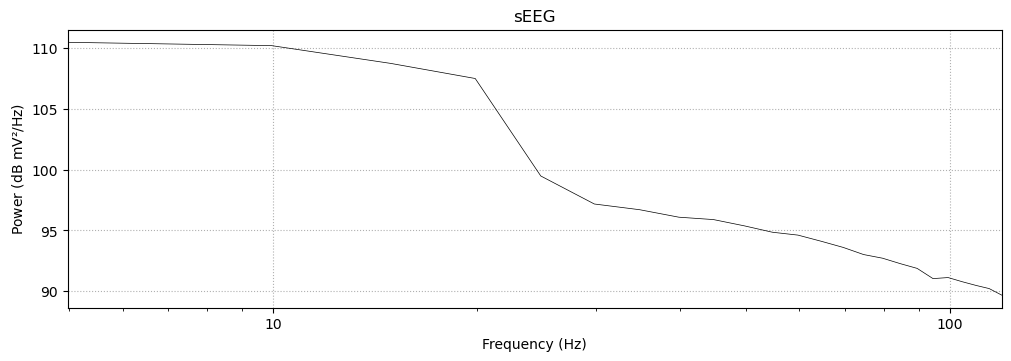

In [58]:
mean_spectrum = epochs_spectrum.average()
mean_spectrum.plot(xscale='log', average=True) 

In [26]:
tIndex = np.logical_and.reduce((
    trl[:,3] >= amp_th[0], 
    trl[:,3] <= amp_th[1], 
    trl[:,4] > minfreq, 
    trl[:,5] < sharptransient_th, 
    trl[:,6] > np.median(trl[:,6]) - np.std(trl[:,6]), 
    trl[:,7] == 0
))
print(tIndex)
#

NameError: name 'trl' is not defined

TEST: funcion para identificar discharges en el mismo trial que los ripples

In [35]:
## ---------------
trial_start = rippletrough-t_range*srate
trial_end = rippletrough+t_range*srate
discharge_pks

print(trial_start, trial_end, discharge_pks)
## ---------------

nodischarges = np.zeros(len(trial_start))

for tr_idx in range(len(trial_start)):

    currentepoch_start = trial_start[tr_idx]
    currentepoch_end = trial_end[tr_idx]
    #print(currentepoch_start, currentepoch_end)
    nodischarges[tr_idx] = np.sum((discharge_pks >= currentepoch_start) & (discharge_pks <= currentepoch_end))

print(nodischarges)


[ -1570.    606.   2178.   3905.  90828.  94665.  95917.  96964. 102279.
 102950. 103558. 104452. 105575. 112213. 113909. 116010. 118953. 124624.
 125176. 126010. 127077. 128640. 133326. 140660. 144738. 146550. 150831.
 152215. 161147. 161970. 164853. 171383. 176401. 187720. 188336. 189083.
 189817. 190351. 191004. 191672. 192419. 193070. 193574. 194164. 195290.
 195917. 196789. 197535. 198467. 198985. 199487. 200127. 200662. 201198.
 202019. 204028. 204843. 219064. 230054. 230820. 231885. 232492. 233051.
 233665. 234906. 242067. 247606. 281785. 291965. 323176. 333192. 341105.
 356111. 456288. 460894. 470866.] [  3430.   5606.   7178.   8905.  95828.  99665. 100917. 101964. 107279.
 107950. 108558. 109452. 110575. 117213. 118909. 121010. 123953. 129624.
 130176. 131010. 132077. 133640. 138326. 145660. 149738. 151550. 155831.
 157215. 166147. 166970. 169853. 176383. 181401. 192720. 193336. 194083.
 194817. 195351. 196004. 196672. 197419. 198070. 198574. 199164. 200290.
 200917. 201789. 

In [33]:
tr_idx = 55

currentepoch_start = trial_start[tr_idx]
currentepoch_end = trial_end[tr_idx]
print(currentepoch_start, currentepoch_end)

print( np.sum((discharge_pks >= currentepoch_start) & (discharge_pks <= currentepoch_end)) ) 

nodischarges[tr_idx] = np.sum((discharge_pks >= currentepoch_start) & (discharge_pks <= currentepoch_end))

204028.0 209028.0
2


In [105]:
print(np.where((discharge_pks>=200000) & (discharge_pks<=300000)))
print((discharge_pks>=200000) & (discharge_pks<=300000))

(array([1, 2, 3]),)
[False  True  True  True False False False False False]


In [78]:
trl = np.column_stack((rippletrough-t_range*srate, rippletrough+t_range*srate, np.full(len(rippletrough), -2.5*srate), pks, ripplepeaks, sharptransient, width))
print(trl[0,:])

[-1.57000000e+03  3.43000000e+03 -2.50000000e+03  4.87082992e+00
  1.65000000e+02  1.03618184e+00  1.59246528e-01]


In [61]:
# TEST para la funcion que determina las caracteristicas de los ripples (ripplechar)

# - Pre-define output variables -
# -------------------------------------------------------------------------
# Pre-define output variables
ripplepeaks = np.full(len(locs), np.nan)
rippletrough = np.full(len(locs), np.nan)
sharptransient = np.full(len(locs), np.nan)

# - Go through ripple candidates -
for idx in range(len(locs)):
    
    # 1. Determine window -------------------------------------------------
    s_start = np.round(locs[idx] - maxsamples/2).astype(int) # start sample
    s_end = np.round(locs[idx] + maxsamples/2).astype(int) # stop sample
    datasegm_trial  = signal_in[0,s_start:s_end]
    datasegm_time = times[s_start:s_end]
    
    # 2. Find all troughs close to candidate ripple peak ------------------
    idxloc, _ = signal.find_peaks((-1)*datasegm_trial)
    pks2 = (-1)*datasegm_trial[idxloc]
    idxloc = idxloc + s_start # offset to the real indexs
    
    # 3. Save ripple characteristics --------------------------------------
    if len(idxloc) == 0 or len(idxloc) == 1:
        print(idx)
        ripplepeaks[idx] = np.nan
        rippletrough[idx] = np.nan
        sharptransient[idx] = np.nan
    else:
        ripplepeaks[idx] = len(idxloc) # - Number of peaks in segment
        rippletrough[idx] = idxloc[np.argmin(np.abs(idxloc-locs[idx]))] # - Datapoint of trough closest to ripple peak idx 

        # 4. Flag sharpest transient ------------------------------------------
        pksz = stats.zscore(pks2)
        pksdiff = pksz[1:]-pksz[:-1]
        sharptransient[idx] = np.max(np.abs(pksdiff))                    # - Mark sharpest transient for later spike removal


#return ripplepeaks, rippletrough, sharptransient

#print(ripplepeaks, rippletrough, sharptransient)


In [60]:
print(len(idxloc))

4


In [7]:
print(times.shape)
print(filt_signal_in_envelope.shape)
#print(times[locs])
print(filt_signal_in_envelope[0,locs])

(500000,)
(1, 500000)
[ 4.87082992  2.91757945  2.57857237  2.10227395  2.51546604  5.08684021
  2.18019737  2.57210587 10.46986065  3.41698475  3.67075113  2.74097915
  2.2996239   7.72343543  2.25385835  2.11338141  2.01832542  2.07169265
  5.10463185  2.01494404  2.17745499  3.2177211   2.77763821  2.90211307
  2.30573067  2.52891277  2.79435575  2.59455965  2.12435841  2.14611511
  2.24302935  2.09367218  5.47851155  3.06993282  4.73802656  7.36798456
  7.59772142 10.83102623  8.12862065  6.52394684  6.67562382  4.34330607
  4.5075732   2.56573771  3.18369741 10.83576988 10.58748703 14.24005339
 13.78419363  9.66637188  3.08712168  3.74410529  8.15150527 13.76653302
  3.22178052  3.56593849  2.63205541  2.36293108  2.43248437  2.35257092
  5.01315637  2.8635101   4.01551021  3.5453666   2.17748814  3.41319487
  2.24441423  2.61904736  2.01842679 11.87047148  4.72000971  2.54443748
  3.82376576  6.66464553  2.18249295  2.9196583 ]


In [11]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex='all')

# Plot signal_in in the first subplot
axs[0].plot(times, signal_in[0], label='Original Signal',zorder=-1)
axs[0].scatter(times[locs.astype(int)], signal_in[0, locs.astype(int)]+50, color='red', marker="v", s=70, label='Identified Peaks',zorder=1)
axs[0].set_title('Original Signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].legend()

# Plot filt_signal_in, filt_signal_in_envelope, and identified peaks in the second subplot
axs[1].scatter(times[locs.astype(int)], filt_signal_in_envelope[0, locs.astype(int)], color='red', marker="v", s=70, label='Identified Peaks',zorder=1)
axs[1].axhline(y=2, color='r', linestyle='--', label='threshold')
axs[1].plot(times, filt_signal_in[0], label='Filtered Signal',zorder=-1)
axs[1].plot(times, filt_signal_in_envelope[0], label='Filtered Signal Envelope',zorder=-1)
axs[1].set_title('Filtered Signal and Envelope with Identified Peaks')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].legend()

plt.tight_layout()
plt.show()

In [23]:
# TEST para general el algoritmo de deteccion de IEDs

# ------------
signal_in = ieeg_signal
srate = int(fsample)
t_epoch = [2.5, 2.5]
# ------------

# 1. Get envelope from raw signal
amplit_envelope = np.abs(signal.hilbert(signal_in))
amplit_envelope = stats.zscore(amplit_envelope, axis=1) 

# 2. Band-pass filtering 
filter_order = 4
low_cut = 25 # low cut-off frequency for high-pass filter
b_hp, a_hp = signal.butter(filter_order, (low_cut / srate) * 2, 'high')
high_cut = 80 # high cut-off frequency for low-pass filter
b_lp, a_lp = signal.butter(filter_order, (high_cut / srate) * 2, 'low')

# apply filtering and get envelope
filt_signal_in = signal.filtfilt(b_hp, a_hp, signal_in) # HP
filt_signal_in = signal.filtfilt(b_lp, a_lp, filt_signal_in) #LP

filt_signal_in_envelope = np.abs(signal.hilbert(filt_signal_in))

# 3. Normalize
filt_signal_in_envelope = stats.zscore(filt_signal_in_envelope, axis=1);

# 4. Detect events above threshold and time criterion
cutoff  = 2
min_t   = 0.02 * srate
max_t   = 0.1 * srate

# 5. only find consecutive segments 
aboveThreshold = (filt_signal_in_envelope > cutoff) # - Samples of threshhold
aboveThreshold[amplit_envelope < cutoff] = 0;  # - Remove if raw sd is < cutoff 

In [59]:
#signal_in_IEDs = signal_in.copy()

# Identify continuous one and apply time criterion
spanLocs = label(aboveThreshold) # Label connected regions
regions = regionprops(spanLocs) # Measure region properties (area)
spanLength = np.array([region.area for region in regions]) # Extract the length (area) of each region
goodSpans = np.where((spanLength > min_t) & (spanLength < max_t))[0] # Find indices of spans with lengths within the specified range

# 6. Create trl matrix 
trl = np.zeros((len(goodSpans),4))

detected_IED = []

for g in range(len(goodSpans)):

    currentepochidx = np.where(spanLocs == goodSpans[g])[1]
    currentepochvals = filt_signal_in_envelope[0,currentepochidx]

    # Find the max in this range
    maxloc = np.argmax(currentepochvals)
    maxloc = maxloc + currentepochidx[0]

    detected_IED.append([times[maxloc],np.max(currentepochvals)])

    # Create the trl
    trl[g,:] = [maxloc, maxloc-np.abs(t_epoch[0])*srate, maxloc+np.abs(t_epoch[1])*srate, np.abs(t_epoch[0])*srate]

# Convert the list to a numpy array
detected_IED = np.array(detected_IED)

In [66]:
# 7. Eliminate events that are within 1 sec -------------------------------
tr_el = np.zeros(trl.shape[0])

for tr in range(1, trl.shape[0]):
    if (trl[tr,0] - trl[tr-1,0]) <= srate:
        tr_el[tr] = 1
    else:
        pass

print(tr_el)

trl = np.delete(trl, np.where(tr_el == 1), axis=0)



[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0.]


'tr_el = zeros(size(trl,1),1);\n\nfor tr = 2:size(trl,1)    \n   if (trl(tr,1) - trl(tr-1,1)) <= srate\n       tr_el(tr) = 1;\n   else\n   end\nend\ntrl(find(tr_el == 1),:) = [];'

In [67]:
fig1, ax1 = plt.subplots(nrows=3,ncols=1,figsize=(10, 6), sharex='all')

# Plot raw
ax1[0].plot(times, signal_in[0], label='raw signal')
ax1[0].set_title('Raw signal')
ax1[0].scatter(detected_IED[:,0], detected_IED[:,1], color='r', marker='*', label='detected IEDs')
ax1[0].grid()

# Plot amplit_envelope
ax1[1].plot(times, amplit_envelope[0], label='amplit_envelope')
ax1[1].axhline(y=cutoff, color='r', linestyle='--', label='cutoff')
ax1[1].set_title('Amplitude envelope')
ax1[1].grid()

# Plot filt_signal_in_envelope
ax1[2].plot(times, filt_signal_in_envelope[0], label='filt_signal_in_envelope')
ax1[2].axhline(y=cutoff, color='r', linestyle='--', label='cutoff')
ax1[2].set_title('Filtered signal envelope')
ax1[2].grid()

# Show the plot
plt.show()